In [ ]:
!ls -alt
!pwd

total 20
drwxr-xr-x 1 root root 4096 Jan  2 17:03 .
drwx------ 5 root root 4096 Jan  2 17:03 drive
drwxr-xr-x 1 root root 4096 Jan  2 17:01 ..
drwxr-xr-x 1 root root 4096 Dec 19 14:20 sample_data
drwxr-xr-x 4 root root 4096 Dec 19 14:20 .config
/content


# Data

In [218]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(filename, size):
    ## load data
    data_file = pd.read_csv(filename, header=None)
    data_file = data_file.dropna()

    # make train and test sets
    data_x = np.array(data_file.drop(data_file.columns[-1], axis=1))
    data_y = np.array(data_file[data_file.columns[-1]])

    train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,
                                                        test_size=size,
                                                        stratify=data_y,
                                                        random_state=42)

    return train_x, test_x, train_y, test_y


In [219]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def preprocess_data(train_x, test_x, train_y, pca_components=None):
    # normalize
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)

    if pca_components:
        # pca for outliers
        pca = PCA(n_components=num_components)
        x_pca = pca.fit_transform(train_x)

        x_reconstructed = pca.inverse_transform(x_pca)
        reconstruction_errors = np.linalg.norm(train_x - x_reconstructed, axis=1)

        threshold = np.percentile(reconstruction_errors, 99.95)

        train_x = train_x[reconstruction_errors <= threshold]
        train_y = train_y[reconstruction_errors <= threshold]

    if pca_components:
        # pca for dimensionality
        pca = PCA(n_components=pca_components)
        train_x = pca.fit_transform(train_x)
        test_x = pca.transform(test_x)

    return train_x, test_x, train_y

In [234]:
# decide on pca components
import plotly.graph_objects as go

def de_correlate_df(df):
    X_aux = df.copy()
    for col in df.columns:
        X_aux[col] = df[col].sample(len(df)).values

    return X_aux

df = pd.read_csv("./drive/MyDrive/Sxoli/9o eksamino/protipa/datasetC.csv", header=None)

pca = PCA()
pca.fit(df)
original_variance = pca.explained_variance_ratio_

N_permutations = 100
variance = np.zeros((N_permutations, len(df.columns)))

for i in range(N_permutations):
    X_aux = de_correlate_df(df)

    pca.fit(X_aux)
    variance[i, :] = pca.explained_variance_ratio_

p_val = np.sum(variance > original_variance, axis=0) / N_permutations
num_components = next(i for i, value in enumerate(p_val) if value > 0) - 1

fig = go.Figure()
fig.add_trace(go.Scatter(x=[f'PC{i}' for i in range(len(df.columns))], y=p_val, name='p-value on significance'))
fig.update_layout(title="PCA Permutation Test p-values")

# k-NN

## Cross-Validation

In [227]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# loading data
train_x, test_x, train_y, test_y = load_data("./drive/MyDrive/Sxoli/9o eksamino/protipa/datasetC.csv", 0.2)

train_x, test_x, train_y = preprocess_data(train_x, test_x, train_y, num_components)


# grid search
params = {
    'n_neighbors': [2, 4, 8, 16, 32],
    'weights': ['uniform', 'distance'],
}

model = KNeighborsClassifier()

grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid.fit(train_x, train_y)
print("Best parameters:", grid.best_params_)

best_model = grid.best_estimator_

Best parameters: {'n_neighbors': 16, 'weights': 'distance'}


## Results

Accuracy: 89.20%


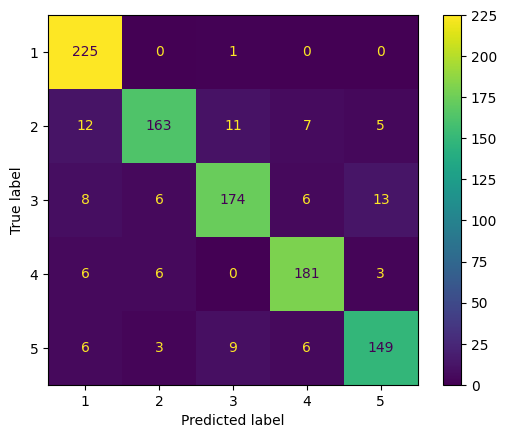

In [228]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


# test model
pred_y = best_model.predict(test_x)

# evaluate the performance of the model
accuracy = accuracy_score(test_y, pred_y)
ConfusionMatrixDisplay.from_predictions(test_y, pred_y)

print(f'Accuracy: {100*accuracy:.2f}%')
plt.show()


# MLP

## The network

In [235]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, hidden_dim, input_dim, output_dim):
        super().__init__()
        self.flatten = nn.Flatten()

        layers = []
        sizes = [input_dim] + hidden_dim + [output_dim]

        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(nn.ReLU())

        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

batch_size = 32

## Train & Test

In [236]:
def train_loop(model, dataloader, loss_function, optimizer, device):
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_function(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return

In [237]:
def test(model, dataloader, device, return_accuracy=False):
    size = len(dataloader) * batch_size
    correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

    correct /= size

    if return_accuracy:
      return 100 * correct

## Preprocess Data

In [238]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_x, test_x, train_y, test_y = load_data("./drive/MyDrive/Sxoli/9o eksamino/protipa/datasetC.csv", 0.2)
train_x, test_x, train_y = preprocess_data(train_x, test_x, train_y, num_components)

train_x = np.float32(train_x)
test_x = np.float32(test_x)
train_y = train_y - 1
test_y = test_y - 1

train_x = torch.from_numpy(train_x)
test_x = torch.from_numpy(test_x)
train_y = torch.from_numpy(train_y)
test_y = torch.from_numpy(test_y)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [239]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## GridSearch

In [252]:
input_dim = train_x.shape[1]
output_dim = max(train_y) + 1

hidden_dims = [input_dim // 2, 2 * output_dim]
learning_rates = [1e-3, 1e-4, 1e-5]
epochs = 100

loss_function = nn.CrossEntropyLoss()

best_accuracy = 0.0
best_params = {}
for lr in learning_rates:
    print(f'-----Learning Rate={lr}------')

    model = Network(hidden_dims, input_dim, output_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        train_loop(model, train_loader, loss_function, optimizer, device)

        accuracy = test(model, test_loader, device, return_accuracy=True)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'epochs': epoch}
            torch.save(model.state_dict(), 'best_model.pth')

        if epoch % 20 == 0:
            print(f'Epoch {epoch}')
            print(f"Test Error: \n Accuracy: {accuracy:.2f}%\n")

print("\nTraining completed!")
print("\nBest parameters:", best_params)

-----Learning Rate=0.001------
Epoch 20
Test Error: 
 Accuracy: 83.79%

Epoch 40
Test Error: 
 Accuracy: 85.25%

Epoch 60
Test Error: 
 Accuracy: 85.84%

Epoch 80
Test Error: 
 Accuracy: 85.55%

Epoch 100
Test Error: 
 Accuracy: 85.55%

-----Learning Rate=0.0001------
Epoch 20
Test Error: 
 Accuracy: 74.22%

Epoch 40
Test Error: 
 Accuracy: 78.52%

Epoch 60
Test Error: 
 Accuracy: 81.15%

Epoch 80
Test Error: 
 Accuracy: 81.35%

Epoch 100
Test Error: 
 Accuracy: 81.84%

-----Learning Rate=1e-05------
Epoch 20
Test Error: 
 Accuracy: 23.44%

Epoch 40
Test Error: 
 Accuracy: 33.40%

Epoch 60
Test Error: 
 Accuracy: 43.46%

Epoch 80
Test Error: 
 Accuracy: 47.56%

Epoch 100
Test Error: 
 Accuracy: 49.32%


Training completed!

Best parameters: {'learning_rate': 0.001, 'epochs': 91}


## Final Results

In [253]:
print("Load the best model")
best_model = Network(hidden_dims, input_dim, output_dim).to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

accuracy = test(best_model, test_loader, device, return_accuracy=True)
print(f"Final accuracy: {accuracy:.2f}%\n")


Load the best model
Final accuracy: 86.13%



# SVM

## Cross-Validation

In [224]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# loading data
train_x, test_x, train_y, test_y = load_data("./drive/MyDrive/Sxoli/9o eksamino/protipa/datasetC.csv", 0.2)

train_x, test_x, train_y = preprocess_data(train_x, test_x, train_y, num_components)


# grid search
params = {
    'C': [10.0],
    'gamma': ['auto']
}

model = SVC(random_state=42)

grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid.fit(train_x, train_y)
print("Best parameters:", grid.best_params_)

best_model = grid.best_estimator_

Best parameters: {'C': 10.0, 'gamma': 'auto'}


## Results

Accuracy: 90.90%


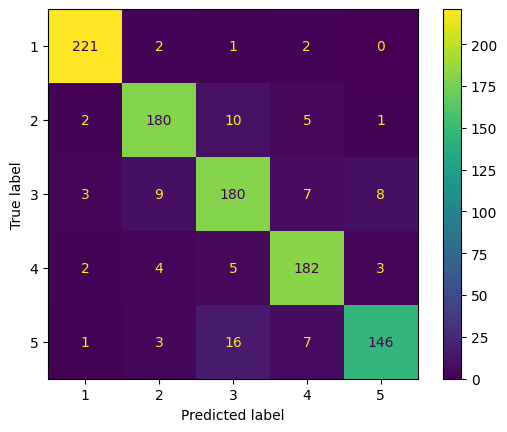

In [226]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# test model
pred_y = best_model.predict(test_x)

# evaluate the performance of the model
accuracy = accuracy_score(test_y, pred_y)
ConfusionMatrixDisplay.from_predictions(test_y, pred_y)

print(f'Accuracy: {100*accuracy:.2f}%')
plt.show()
